In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import operator
import re
import plotly.offline as py
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go

from pandas.io.json import json_normalize
from plotly import tools
py.init_notebook_mode(connected=True)
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
color = sns.color_palette()
np.random.seed(13)
%matplotlib inline
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['embeddings', 'train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
print("Train shape : ",train.shape)
print("Test shape : ",test.shape)

Train shape :  (1306122, 3)
Test shape :  (56370, 2)


In [3]:
def load_embed(file):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    if file == '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec':
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>100)
    else:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
        
    return embeddings_index

In [4]:
glove = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
paragram =  '../input/embeddings/paragram_300_sl999/paragram_300_sl999.txt'
wiki_news = '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'

In [5]:
print("Extracting GloVe embedding")
embed_glove = load_embed(glove)
print("Extracting Paragram embedding")
embed_paragram = load_embed(paragram)
print("Extracting FastText embedding")
embed_fasttext = load_embed(wiki_news)

Extracting GloVe embedding
Extracting Paragram embedding
Extracting FastText embedding


In [6]:
def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [7]:
def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

In [8]:
vocab = build_vocab(train['question_text'])

In [9]:
print("Glove : ")
oov_glove = check_coverage(vocab, embed_glove)
print("Paragram : ")
oov_paragram = check_coverage(vocab, embed_paragram)
print("FastText : ")
oov_fasttext = check_coverage(vocab, embed_fasttext)

Glove : 
Found embeddings for 33.02% of vocab
Found embeddings for  88.15% of all text
Paragram : 
Found embeddings for 19.54% of vocab
Found embeddings for  72.21% of all text
FastText : 
Found embeddings for 30.05% of vocab
Found embeddings for  87.66% of all text


In [10]:
train['lowered_question'] = train['question_text'].apply(lambda x: x.lower())

In [11]:
vocab_low = build_vocab(train['lowered_question'])

In [12]:
print("Glove : ")
oov_glove = check_coverage(vocab_low, embed_glove)
print("Paragram : ")
oov_paragram = check_coverage(vocab_low, embed_paragram)
print("FastText : ")
oov_fasttext = check_coverage(vocab_low, embed_fasttext)

Glove : 
Found embeddings for 27.38% of vocab
Found embeddings for  87.87% of all text
Paragram : 
Found embeddings for 31.26% of vocab
Found embeddings for  88.21% of all text
FastText : 
Found embeddings for 22.02% of vocab
Found embeddings for  87.14% of all text


In [13]:
def add_lower(embedding, vocab):
    count = 0
    for word in vocab:
        if word in embedding and word.lower() not in embedding:  
            embedding[word.lower()] = embedding[word]
            count += 1
    print(f"Added {count} words to embedding")

In [14]:
print("Glove : ")
add_lower(embed_glove, vocab)
print("Paragram : ")
add_lower(embed_paragram, vocab)
print("FastText : ")
add_lower(embed_fasttext, vocab)

Glove : 
Added 14725 words to embedding
Paragram : 
Added 0 words to embedding
FastText : 
Added 27176 words to embedding


In [15]:
print("Glove : ")
oov_glove = check_coverage(vocab_low, embed_glove)
print("Paragram : ")
oov_paragram = check_coverage(vocab_low, embed_paragram)
print("FastText : ")
oov_fasttext = check_coverage(vocab_low, embed_fasttext)

Glove : 
Found embeddings for 30.64% of vocab
Found embeddings for  88.19% of all text
Paragram : 
Found embeddings for 31.26% of vocab
Found embeddings for  88.21% of all text
FastText : 
Found embeddings for 28.05% of vocab
Found embeddings for  87.73% of all text


In [16]:
oov_glove[:10]

[('india?', 16394),
 ("what's", 13369),
 ('it?', 13158),
 ('do?', 8766),
 ('life?', 7791),
 ('why?', 7369),
 ('you?', 6314),
 ('me?', 6241),
 ('them?', 6141),
 ('time?', 5742)]

In [17]:
oov_glove[:20]

[('india?', 16394),
 ("what's", 13369),
 ('it?', 13158),
 ('do?', 8766),
 ('life?', 7791),
 ('why?', 7369),
 ('you?', 6314),
 ('me?', 6241),
 ('them?', 6141),
 ('time?', 5742),
 ('world?', 5525),
 ('people?', 5008),
 ('quora?', 4657),
 ('like?', 4490),
 ('for?', 4450),
 ('work?', 4219),
 ('2017?', 4050),
 ('mean?', 3980),
 ('2018?', 3594),
 ("isn't", 3509)]

In [18]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because",
                       "could've": "could have", "couldn't": "could not", "didn't": "did not",
                       "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not",
                       "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is",
                       "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                       "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have",
                       "I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                       "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have",
                       "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will",
                       "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                       "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
                       "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                       "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
                       "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                       "she'd": "she would", "she'd've": "she would have", "she'll": "she will",
                       "she'll've": "she will have", "she's": "she is", "should've": "should have",
                       "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                       "so's": "so as", "this's": "this is","that'd": "that would",
                       "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                       "there'd've": "there would have", "there's": "there is", "here's": "here is",
                       "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
                       "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have",
                       "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                       "weren't": "were not", "what'll": "what will", "what'll've": "what will have",
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is",
                       "when've": "when have", "where'd": "where did", "where's": "where is", 
                       "where've": "where have", "who'll": "who will", "who'll've": "who will have",
                       "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have",
                       "will've": "will have", "won't": "will not", "won't've": "will not have", 
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
                       "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
                       "y'all're": "you all are","y'all've": "you all have","you'd": "you would",
                       "you'd've": "you would have", "you'll": "you will", "you'll've":"you will have",
                       "you're": "you are", "you've": "you have" }

In [19]:
def known_contractions(embed):
    known = []
    for contract in contraction_mapping:
        if contract in embed:
            known.append(contract)
    return known


In [20]:
print("- Known Contractions -")
print("   Glove :")
print(known_contractions(embed_glove))
print("   Paragram :")
print(known_contractions(embed_paragram))
print("   FastText :")
print(known_contractions(embed_fasttext))

- Known Contractions -
   Glove :
["can't", "'cause", "didn't", "doesn't", "don't", "I'd", "I'll", "I'm", "I've", "i'd", "i'll", "i'm", "i've", "it's", "ma'am", "o'clock", "that's", "you'll", "you're"]
   Paragram :
["can't", "'cause", "didn't", "doesn't", "don't", "i'd", "i'll", "i'm", "i've", "it's", "ma'am", "o'clock", "that's", "you'll", "you're"]
   FastText :
[]


In [21]:
def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

In [22]:
train['treated_question'] = train['lowered_question'].apply(lambda x: clean_contractions(x, contraction_mapping))

In [23]:
vocab = build_vocab(train['treated_question'])
print("Glove : ")
oov_glove = check_coverage(vocab, embed_glove)
print("Paragram : ")
oov_paragram = check_coverage(vocab, embed_paragram)
print("FastText : ")
oov_fasttext = check_coverage(vocab, embed_fasttext)

Glove : 
Found embeddings for 30.79% of vocab
Found embeddings for  88.56% of all text
Paragram : 
Found embeddings for 31.41% of vocab
Found embeddings for  88.58% of all text
FastText : 
Found embeddings for 28.19% of vocab
Found embeddings for  88.44% of all text


In [24]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

In [25]:
def unknown_punct(embed, punct):
    unknown = ''
    for p in punct:
        if p not in embed:
            unknown += p
            unknown += ' '
    return unknown

In [26]:
print("Glove :")
print(unknown_punct(embed_glove, punct))
print("Paragram :")
print(unknown_punct(embed_paragram, punct))
print("FastText :")
print(unknown_punct(embed_fasttext, punct))

Glove :
“ ” ’ ∞ θ ÷ α • à − β ∅ ³ π ‘ ₹ ´ ° £ € × ™ √ ² — – 
Paragram :
“ ” ’ ∞ θ ÷ α • à − β ∅ ³ π ‘ ₹ ´ ° £ € × ™ √ ² — – 
FastText :
_ ` 


In [27]:
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }

In [28]:
def clean_special_chars(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  # Other special characters that I have to deal with in last
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

In [29]:
train['treated_question'] = train['treated_question'].apply(lambda x: clean_special_chars(x, punct, punct_mapping))

In [30]:
vocab = build_vocab(train['treated_question'])
print("Glove : ")
oov_glove = check_coverage(vocab, embed_glove)
print("Paragram : ")
oov_paragram = check_coverage(vocab, embed_paragram)
print("FastText : ")
oov_fasttext = check_coverage(vocab, embed_fasttext)

Glove : 
Found embeddings for 69.52% of vocab
Found embeddings for  99.58% of all text
Paragram : 
Found embeddings for 73.99% of vocab
Found embeddings for  99.63% of all text
FastText : 
Found embeddings for 61.21% of vocab
Found embeddings for  99.45% of all text


In [31]:
oov_fasttext[:100]

[('quorans', 858),
 ('bitsat', 562),
 ('comedk', 357),
 ('kvpy', 356),
 ('quoran', 311),
 ('wbjee', 237),
 ('articleship', 208),
 ('viteee', 186),
 ('upes', 157),
 ('fortnite', 156),
 ('marksheet', 140),
 ('afcat', 123),
 ('uceed', 123),
 ('dropshipping', 115),
 ('bhakts', 115),
 ('iitjee', 108),
 ('machedo', 108),
 ('upsee', 105),
 ('bnbr', 100),
 ('chsl', 99),
 ('amcat', 94),
 ('josaa', 93),
 ('alshamsi', 92),
 ('iitian', 91),
 ('unacademy', 86),
 ('qoura', 82),
 ('zerodha', 80),
 ('icos', 76),
 ('nmat', 76),
 ('hairfall', 73),
 ('jiit', 72),
 ('doklam', 70),
 ('kavalireddi', 69),
 ('lnmiit', 68),
 ('muoet', 66),
 ('woocommerce', 65),
 ('metoo', 64),
 ('nicmar', 62),
 ('vajiram', 60),
 ('modiji', 60),
 ('adhaar', 59),
 ('zebpay', 58),
 ('infjs', 57),
 ('elitmus', 57),
 ('srmjee', 56),
 ('hackerrank', 54),
 ('pubg', 54),
 ('gixxer', 53),
 ('awdhesh', 52),
 ('aiq', 51),
 ('sibm', 51),
 ('golang', 49),
 ('koinex', 48),
 ('mahadasha', 47),
 ('mhcet', 45),
 ('binance', 45),
 ('byju', 44),

In [32]:
mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite',
                'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization',
                'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 
                'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much',
                'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best',
                'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate',
                "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum',
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018',
                'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess',
                "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization',
                'demonitization': 'demonetization', 'demonetisation': 'demonetization'}

In [33]:
def correct_spelling(x, dic):
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x


In [34]:
train['treated_question'] = train['treated_question'].apply(lambda x: correct_spelling(x, mispell_dict))


In [35]:
vocab = build_vocab(train['treated_question'])
print("Glove : ")
oov_glove = check_coverage(vocab, embed_glove)
print("Paragram : ")
oov_paragram = check_coverage(vocab, embed_paragram)
print("FastText : ")
oov_fasttext = check_coverage(vocab, embed_fasttext)

Glove : 
Found embeddings for 69.52% of vocab
Found embeddings for  99.58% of all text
Paragram : 
Found embeddings for 73.99% of vocab
Found embeddings for  99.63% of all text
FastText : 
Found embeddings for 61.21% of vocab
Found embeddings for  99.45% of all text


In [36]:
train.head()

,qid,question_text,target,lowered_question,treated_question
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,how did quebec nationalists see their province...,how did quebec nationalists see their province...
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,"do you have an adopted dog, how would you enco...","do you have an adopted dog , how would you en..."
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,why does velocity affect time? does velocity a...,why does velocity affect time ? does velocity...
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,how did otto von guericke used the magdeburg h...,how did otto von guericke used the magdeburg h...
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,can i convert montra helicon d to a mountain b...,can i convert montra helicon d to a mountain b...


In [37]:
sincere_questions = train[train['target'] == 0]
insincere_questions = train[train['target'] == 1]
insincere_questions.tail(5)

,qid,question_text,target,lowered_question,treated_question
1306093,fffeba722d9b371bd1b9,How is it to have intimate relation with your ...,1,how is it to have intimate relation with your ...,how is it to have intimate relation with your ...
1306094,fffee269360dd0d3947a,Why is it when singers have lyrics about voice...,1,why is it when singers have lyrics about voice...,why is it when singers have lyrics about voice...
1306099,ffff0e4ea1bb6e16feec,Do pakis smell of curry and shit?,1,do pakis smell of curry and shit?,do pakis smell of curry and shit ?
1306103,ffff3f0a2449ffe4b9ff,Isn't Trump right after all? Why should the US...,1,isn't trump right after all? why should the us...,is not trump right after all ? why should the...
1306112,ffffa5b0fa76431c063f,Are you ashamed of being an Indian?,1,are you ashamed of being an indian?,are you ashamed of being an indian ?


Now let us try to create new features

## Average Length of Sincere vs. Insincere

In [38]:
sincere_questions['length'] = sincere_questions['question_text'].apply(lambda x : len(x))
insincere_questions['length'] = insincere_questions['question_text'].apply(lambda x : len(x))
train['length'] = train['question_text'].apply(lambda x : len(x))

Seems like length doesn't explain insincerity but certainly has some information to add to the context. lets check the highest length question

In [39]:
print(train.iloc[443216]['treated_question'])
train[train['length'] == train['length'].max()]

what is  [ math ]   \  frac {   \  int  -   { 1x ^ 5 }  ^  { 3x ^  {   -  5 }  }    \  tan (   \  tan (  {   \  boxed {   \  int  -   { 1x ^ 0 }  ^  { 1x ^ 2 }    \  sum  -   {   \  varpi = 1 }  ^  {   \  infty }    \  int  -   { 2x ^  {   -  3 }  }  ^  { 2x ^ 2 }    \  sum  -   {   \  alpha = 7 }  ^  {   \  infty }    \  underbrace {   \  sqrt [ 2 ]  { 1x ^ 5 }  }   -   {   \  text { gauss  '  s law of theoretical probability .  }  }  d  \  tau dx }  }  ^  { 1x ^ 0 }  )  )  d  \  mu }  {   \  int  -   { 2x ^  {   -  3 }  }  ^  { 1x ^ 5 }    \  cos (   \  int  -   { 2x ^ 2 }  ^  { 1x ^  {   -  3 }  }    \  frac {   \  sqrt [ 2 ]  {   \  overbrace {   \  underbrace {   \  frac { 3x ^ 3 + 3x ^ 5 }  {   \  sqrt [ 3 ]  { 2x ^  {   -  3 }  }  }  }   -   {   \  text { gauss  '  s law of theoretical probability .  }  }    \  times   \  overbrace {   \  tan ( 2x ^ 0 )  }  ^  {   \  text { gauss  '  s law of theoretical probability .  }  }   -    \  sum  -   { 4 = 7 }  ^  {   \  infty }    \  b

,qid,question_text,target,lowered_question,treated_question,length
443216,56da6b6875d686b48fde,What is [math]\frac{\int_{1x^5}^{3x^{-5}} \tan...,1,what is [math]\frac{\int_{1x^5}^{3x^{-5}} \tan...,what is [ math ] \ frac { \ int - { ...,1017


In [40]:
for i in range(0,101,10):
    print('The ',i,'Th percentile is=',train.length.quantile(i/100))

The  0 Th percentile is= 1.0
The  10 Th percentile is= 34.0
The  20 Th percentile is= 42.0
The  30 Th percentile is= 48.0
The  40 Th percentile is= 54.0
The  50 Th percentile is= 60.0
The  60 Th percentile is= 68.0
The  70 Th percentile is= 78.0
The  80 Th percentile is= 94.0
The  90 Th percentile is= 122.0
The  100 Th percentile is= 1017.0


In [41]:
for i in range(90,101,1):
    print('The ',i,'Th percentile is=',train.length.quantile(i/100))

The  90 Th percentile is= 122.0
The  91 Th percentile is= 127.0
The  92 Th percentile is= 131.0
The  93 Th percentile is= 137.0
The  94 Th percentile is= 142.0
The  95 Th percentile is= 148.0
The  96 Th percentile is= 155.0
The  97 Th percentile is= 169.0
The  98 Th percentile is= 189.0
The  99 Th percentile is= 219.0
The  100 Th percentile is= 1017.0


In [42]:
for i in range(990,1001,1):
    print('The ',i/10,'Th percentile is=',train.length.quantile(i/1000))

The  99.0 Th percentile is= 219.0
The  99.1 Th percentile is= 223.0
The  99.2 Th percentile is= 227.0
The  99.3 Th percentile is= 231.0
The  99.4 Th percentile is= 235.0
The  99.5 Th percentile is= 239.0
The  99.6 Th percentile is= 242.0
The  99.7 Th percentile is= 245.0
The  99.8 Th percentile is= 247.0
The  99.9 Th percentile is= 249.0
The  100.0 Th percentile is= 1017.0


In [43]:
from tqdm import tqdm # I love this handy tool! 
print(">> Generating Count Based And Demographical Features")
for df in ([train]):
    df['length'] = df['question_text'].apply(lambda x : len(x))
    #df['capitals'] = df['question_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
    #df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['length']),axis=1)
    #df['num_exclamation_marks'] = df['question_text'].apply(lambda comment: comment.count('!'))
    df['num_question_marks'] = df['question_text'].apply(lambda comment: comment.count('?'))
    df['num_punctuation'] = df['question_text'].apply(lambda comment: sum(comment.count(w) for w in '.,;:'))
    df['num_symbols'] = df['question_text'].apply(lambda comment: sum(comment.count(w) for w in '*&$%'))
    df['num_words'] = df['question_text'].apply(lambda comment: len(comment.split()))
    df['num_unique_words'] = df['question_text'].apply(lambda comment: len(set(w for w in comment.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['num_words']
    df['num_smilies'] = df['question_text'].apply(lambda comment: sum(comment.count(w) for w in (':-)', ':)', ';-)', ';)')))
    df['num_sad'] = df['question_text'].apply(lambda comment: sum(comment.count(w) for w in (':-<', ':()', ';-()', ';(')))

>> Generating Count Based And Demographical Features


In [44]:
train[train.columns[2:]].head(8)

,target,lowered_question,treated_question,length,num_question_marks,num_punctuation,num_symbols,num_words,num_unique_words,words_vs_unique,num_smilies,num_sad
0,0,how did quebec nationalists see their province...,how did quebec nationalists see their province...,72,1,0,0,13,13,1.000000,0,0
1,0,"do you have an adopted dog, how would you enco...","do you have an adopted dog , how would you en...",81,1,1,0,16,15,0.937500,0,0
2,0,why does velocity affect time? does velocity a...,why does velocity affect time ? does velocity...,67,2,0,0,10,8,0.800000,0,0
3,0,how did otto von guericke used the magdeburg h...,how did otto von guericke used the magdeburg h...,57,1,0,0,9,9,1.000000,0,0
4,0,can i convert montra helicon d to a mountain b...,can i convert montra helicon d to a mountain b...,77,1,0,0,15,15,1.000000,0,0
5,0,"is gaza slowly becoming auschwitz, dachau or t...","is gaza slowly becoming auschwitz , dachau or...",72,1,1,0,10,10,1.000000,0,0
6,0,why does quora automatically ban conservative ...,why does quora automatically ban conservative ...,113,1,1,0,18,17,0.944444,0,0
7,0,is it crazy if i wash or wipe my groceries off...,is it crazy if i wash or wipe my groceries off...,69,1,1,0,14,14,1.000000,0,0


In [45]:
# List Of Bad Words by Google-Profanity Words 
bad_words = ['cockknocker', 'n1gger', 'ing', 'fukker', 'nympho', 'fucking', 'gook', 'freex', 'arschloch', 'fistfucked', 'chinc', 'raunch', 'fellatio', 'splooge', 'nutsack', 'lmfao', 'wigger', 'bastard', 'asses', 'fistfuckings', 'blue', 'waffle', 'beeyotch', 'pissin', 'dominatrix', 'fisting', 'vullva','ass','vagina','fucked','fuck', 'paki', 'cyberfucker', 'chuj', 'penuus', 'masturbate', 'penis','boob', 'fucks', 'sucked', 'fuckingshit','motherfucker', 'feces', 'panty', 'coital', 'wh00r.', 'whore', 'condom', 'hells', 'foreskin', 'wanker', 'hoer', 'sh1tz', 'shittings', 'wtf', 'recktum', 'dick*', 'porn', 'pasty', 'spik', 'phukked', 'assfuck', 'xxx', 'nigger*', 'ugly', 's_h_i_t', 'mamhoon', 'shit','pornos', 'masturbate','masturbation' ,'mothafucks', 'Mother', 'Fukkah', 'chink', 'pussy', 'motherfucker','palace', 'azazel', 'fistfucking', 'ass-fucker', 'shag', 'chicks', 'duche', 'orgies', 'vag1na','orgasm', 'molest', 'bollock', 'a-hole', 'seduce', 'Cock*', 'dog-fucker', 'shitz', 'Mother', 'Fucker', 'penial', 'bitch', 'junky', 'orifice', '5hit', 'kunilingus', 'cuntbag', 'hump', 'butt', 'fuck', 'titwank', 'schaffer', 'cracker', 'f.u.c.k', 'breasts', 'd1ld0', 'polac', 'boobs', 'ritard', 'fuckup', 'rape', 'hard', 'on', 'skanks', 'coksucka', 'cl1t', 'herpy', 's.o.b.', 'Motha', 'Fucker', 'penus', 'Fukker', 'p.u.s.s.y.', 'faggitt', 'b!tch', 'doosh', 'titty', 'pr1k', 'r-tard', 'gigolo', 'perse', 'lezzies', 'bollock*', 'pedophiliac', 'Ass', 'Monkey', 'mothafucker','sex', 'amcik', 'b*tch', 'beaner', 'masterbat*', 'fucka', 'phuk', 'menses', 'pedophile', 'climax', 'cocksucking', 'fingerfucked', 'asswhole', 'basterdz', 'cahone', 'ahole', 'dickflipper', 'diligaf', 'Lesbian', 'sperm', 'pisser', 'dykes', 'Skanky', 'puuker', 'gtfo', 'orgasim', 'd0ng', 'testicle*', 'pen1s', 'piss-off', '@$$', 'fuck', 'trophy', 'arse*', 'fag', 'organ', 'potty', 'queerz', 'fannybandit', 'muthafuckaz', 'booger', 'pussypounder', 'titt', 'fuckoff', 'bootee', 'schlong', 'spunk', 'rumprammer', 'weed', 'bi7ch', 'pusse', 'blow', 'job', 'kusi*', 'assbanged', 'dumbass', 'kunts', 'chraa', 'cock', 'sucker', 'l3i+ch', 'cabron', 'arrse', 'cnut', 'how', 'to', 'murdep', 'fcuk', 'phuked', 'gang-bang', 'kuksuger', 'mothafuckers', 'ghey', 'clit', 'licker', 'feg', 'ma5terbate', 'd0uche', 'pcp', 'ejaculate', 'nigur', 'clits', 'd0uch3', 'b00bs', 'fucked', 'assbang', 'mutha', 'goddamned', 'cazzo', 'lmao', 'godamn', 'kill', 'coon', 'penis-breath', 'kyke', 'heshe', 'homo', 'tawdry', 'pissing', 'cumshot', 'motherfucker', 'menstruation', 'n1gr', 'rectus', 'oral', 'twats', 'scrot', 'God', 'damn', 'jerk', 'nigga', 'motherfuckin', 'kawk', 'homey', 'hooters', 'rump', 'dickheads', 'scrud', 'fist', 'fuck', 'carpet', 'muncher', 'cipa', 'cocaine', 'fanyy', 'frigga', 'massa', '5h1t', 'brassiere', 'inbred', 'spooge', 'shitface', 'tush', 'Fuken', 'boiolas', 'fuckass', 'wop*', 'cuntlick', 'fucker', 'bodily', 'bullshits', 'hom0', 'sumofabiatch', 'jackass', 'dilld0', 'puuke', 'cums', 'pakie', 'cock-sucker', 'pubic', 'pron', 'puta', 'penas', 'weiner', 'vaj1na', 'mthrfucker', 'souse', 'loin', 'clitoris', 'f.ck', 'dickface', 'rectal', 'whored', 'bookie', 'chota', 'bags', 'sh!t', 'pornography', 'spick', 'seamen', 'Phukker', 'beef', 'curtain', 'eat', 'hair', 'pie', 'mother', 'fucker', 'faigt', 'yeasty', 'Clit', 'kraut', 'CockSucker', 'Ekrem*', 'screwing', 'scrote', 'fubar', 'knob', 'end', 'sleazy', 'dickwhipper', 'ass', 'fuck', 'fellate', 'lesbos', 'nobjokey', 'dogging', 'fuck', 'hole', 'hymen', 'damn', 'dego', 'sphencter', 'queef*', 'gaylord', 'va1jina', 'a55', 'fuck', 'douchebag', 'blowjob', 'mibun', 'fucking', 'dago', 'heroin', 'tw4t', 'raper', 'muff', 'fitt*', 'wetback*', 'mo-fo', 'fuk*', 'klootzak', 'sux', 'damnit', 'pimmel', 'assh0lez', 'cntz', 'fux', 'gonads', 'bullshit', 'nigg3r', 'fack', 'weewee', 'shi+', 'shithead', 'pecker', 'Shytty', 'wh0re', 'a2m', 'kkk', 'penetration', 'kike', 'naked', 'kooch', 'ejaculation', 'bang', 'hoare', 'jap', 'foad', 'queef', 'buttwipe', 'Shity', 'dildo', 'dickripper', 'crackwhore', 'beaver', 'kum', 'sh!+', 'qweers', 'cocksuka', 'sexy', 'masterbating', 'peeenus', 'gays', 'cocksucks', 'b17ch', 'nad', 'j3rk0ff', 'fannyflaps', 'God-damned', 'masterbate', 'erotic', 'sadism', 'turd', 'flipping', 'the', 'bird', 'schizo', 'whiz', 'fagg1t', 'cop', 'some', 'wood', 'banger', 'Shyty', 'f', 'you', 'scag', 'soused', 'scank', 'clitorus', 'kumming', 'quim', 'penis', 'bestial', 'bimbo', 'gfy', 'spiks', 'shitings', 'phuking', 'paddy', 'mulkku', 'anal', 'leakage', 'bestiality', 'smegma', 'bull', 'shit', 'pillu*', 'schmuck', 'cuntsicle', 'fistfucker', 'shitdick', 'dirsa', 'm0f0']
print(">> Words in bad_word list:", len(bad_words))

>> Words in bad_word list: 458


In [46]:
print(">> Generating Features on Bad Words")
for df in ([train]):
    df["badwordcount"] = df['question_text'].apply(lambda comment: sum(comment.count(w) for w in bad_words))
    df['num_chars'] =    df['question_text'].apply(len)
    df["normchar_badwords"] = df["badwordcount"]/df['num_chars']
    df["normword_badwords"] = df["badwordcount"]/df['num_words']

>> Generating Features on Bad Words


In [47]:
train[['badwordcount','num_chars','num_words','normchar_badwords','normword_badwords']].head(8)

,badwordcount,num_chars,num_words,normchar_badwords,normword_badwords
0,4,72,13,0.055556,0.307692
1,4,81,16,0.049383,0.250000
2,4,67,10,0.059701,0.400000
3,3,57,9,0.052632,0.333333
4,6,77,15,0.077922,0.400000
5,2,72,10,0.027778,0.200000
6,5,113,18,0.044248,0.277778
7,3,69,14,0.043478,0.214286


In [48]:
Country = [ 'United States' ,'Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra',
     'Angola',
     'Anguilla',
     'Antarctica',
     'Antigua And Barbuda',
     'Argentina',
     'Armenia',
     'Aruba',
     'Australia',
     'Austria',
     'Azerbaijan',
     'Bahamas',
     'Bahrain',
     'Bangladesh',
     'Barbados',
     'Belarus',
     'Belgium',
     'Belize',
     'Benin',
     'Bermuda',
     'Bhutan',
     'Bolivia',
     'Bosnia And Herzegowina',
     'Botswana',
     'Bouvet Island',
     'Brazil',
     'Brunei Darussalam',
     'Bulgaria',
     'Burkina Faso',
     'Burundi',
     'Cambodia',
     'Cameroon',
     'Canada',
     'Cape Verde',
     'Cayman Islands',
     'Central African Rep',
     'Chad',
     'Chile',
     'China',
    'Christmas Island',
     'Cocos Islands',
     'Colombia',
     'Comoros',
     'Congo',
    'Cook Islands',
    'Costa Rica',
     'Cote D`ivoire',
     'Croatia',
     'Cuba',
     'Cyprus',
     'Czech Republic',
    'Denmark',
     'Djibouti',
     'Dominica',
    'Dominican Republic',
     'East Timor',
     'Ecuador',
     'Egypt',
     'El Salvador',
     'Equatorial Guinea',
     'Eritrea',
     'Estonia',
     'Ethiopia',
     'Falkland Islands',
     'Faroe Islands',
     'Fiji',
     'Finland',
     'France',
     'French Guiana',
     'French Polynesia',
    'French S. Territories',
     'Gabon',
     'Gambia',
     'Georgia',
     'Germany',
     'Ghana',
     'Gibraltar',
     'Greece',
     'Greenland',
     'Grenada',
     'Guadeloupe',
     'Guam',
     'Guatemala',
     'Guinea',
     'Guinea-bissau',
     'Guyana',
     'Haiti',
     'Honduras',
     'Hong Kong',
     'Hungary',
    'Iceland',
     'India',
     'Indonesia',
     'Iran',
    'Iraq',
    'Ireland',
     'Israel',
     'Italy',
    'Jamaica',
     'Japan',
     'Jordan',
     'Kazakhstan',
     'Kenya',
    'Kiribati',
     'North Korea ',
     'South Korea ',
     'Kuwait',
     'Kyrgyzstan',
    'Laos',
     'Latvia',
     'Lebanon',
     'Lesotho',
     'Liberia',
     'Libya',
     'Liechtenstein',
     'Lithuania',
    'Luxembourg',
     'Macau',
     'Macedonia',
     'Madagascar',
     'Malawi',
     'Malaysia',
     'Maldives',
     'Mali',
     'Malta',
    'Marshall Islands',
    'Martinique',
     'Mauritania',
     'Mauritius',
     'Mayotte',
     'Mexico',
     'Micronesia',
     'Moldova',
     'Monaco',
     'Mongolia',
     'Montserrat',
     'Morocco',
     'Mozambique',
     'Myanmar',
     'Namibia',
    'Nauru',
    'Nepal',
     'Netherlands',
     'Netherlands Antilles',
     'New Caledonia',
     'New Zealand',
     'Nicaragua',
    'Niger',
     'Nigeria',
     'Niue',
     'Norfolk Island',
     'Northern Mariana Islands',
    'Norway',
    'Oman',
     'Pakistan',
     'Palau',
     'Panama',
     'Papua New Guinea',
    'Paraguay',
     'Peru',
     'Philippines',
     'Pitcairn',
     'Poland',
     'Portugal',
     'Puerto Rico',
     'Qatar',
     'Reunion',
     'Romania',
     'Russian Federation',
     'Rwanda',
     'Saint Kitts And Nevis',
     'Saint Lucia',
     'St Vincent/Grenadines',
     'Samoa',
     'San Marino',
     'Sao Tome',
     'Saudi Arabia',
     'Senegal',
     'Seychelles',
     'Sierra Leone',
     'Singapore',
     'Slovakia',
     'Slovenia',
     'Solomon Islands',
     'Somalia',
     'South Africa',
     'Spain',
     'Sri Lanka',
     'St. Helena',
     'St.Pierre',
     'Sudan',
     'Suriname',
     'Swaziland',
    'Sweden',
     'Switzerland',
     'Syrian Arab Republic',
     'Taiwan',
    'Tajikistan',
     'Tanzania',
     'Thailand',
     'Togo',
     'Tokelau',
    'Tonga',
     'Trinidad And Tobago',
     'Tunisia',
     'Turkey',
    'Turkmenistan',
    'Tuvalu',
     'Uganda',
     'Ukraine',
     'United Arab Emirates',
     'United Kingdom',
     'Uruguay',
     'Uzbekistan',
     'Vanuatu',
    'Vatican City State',
     'Venezuela',
     'Vietnam',
     'Virgin Islands ',
     'Western Sahara',
     'Yemen',
     'Yugoslavia',
     'Zaire',
     'Zambia',
     'Zimbabwe']

In [49]:
country_names=[i.lower() for i in Country]

In [50]:
print(len(country_names))

230


In [51]:
print(">> Generating Feature on country names")
for df in ([train]):
    df["countrycount"] = df['question_text'].apply(lambda comment: sum(comment.count(w) for w in country_names))


>> Generating Feature on country names


In [52]:
train['countrycount'].value_counts()

0    1294959
1      10627
2        488
3         37
4         11
Name: countrycount, dtype: int64

## Tagging Parts Of Speech And More Feature Engineering..

I suspect that the insincere questions have significant adverbs/adjective that makes them toxic. I am hopeful that these features might model understand various POS structures in the question_text


In [53]:
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

def tag_part_of_speech(text):
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    pos_list = pos_tag(text_splited)
    noun_count = len([w for w in pos_list if w[1] in ('NN','NNP','NNPS','NNS')])
    adjective_count = len([w for w in pos_list if w[1] in ('JJ','JJR','JJS')])
    verb_count = len([w for w in pos_list if w[1] in ('VB','VBD','VBG','VBN','VBP','VBZ')])
    return[noun_count, adjective_count, verb_count]

In [54]:
print(">> Generating POS Features")
for df in ([train]):
    df['nouns'], df['adjectives'], df['verbs'] = zip(*df['treated_question'].apply(
        lambda comment: tag_part_of_speech(comment)))
    df['nouns_vs_length'] = df['nouns'] / df['length']
    df['adjectives_vs_length'] = df['adjectives'] / df['length']
    df['verbs_vs_length'] = df['verbs'] /df['length']
    df['nouns_vs_words'] = df['nouns'] / df['num_words']
    df['adjectives_vs_words'] = df['adjectives'] / df['num_words']
    df['verbs_vs_words'] = df['verbs'] / df['num_words']
    # More Handy Features
    df["count_words_title"] = df["treated_question"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
    df["mean_word_len"] = df["treated_question"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    df['punct_percent']= df['num_punctuation']*100/df['num_words']

>> Generating POS Features


In [55]:
train[['nouns','nouns_vs_length','adjectives_vs_length','verbs_vs_length','nouns_vs_words','adjectives_vs_words','verbs_vs_words','count_words_title','mean_word_len','punct_percent']].head(8)

,nouns,nouns_vs_length,adjectives_vs_length,verbs_vs_length,nouns_vs_words,adjectives_vs_words,verbs_vs_words,count_words_title,mean_word_len,punct_percent
0,4,0.055556,0.000000,0.041667,0.307692,0.000000,0.230769,0,4.285714,0.000000
1,2,0.024691,0.000000,0.074074,0.125000,0.000000,0.375000,0,3.666667,6.250000
2,5,0.074627,0.014925,0.044776,0.500000,0.100000,0.300000,0,4.833333,0.000000
3,4,0.070175,0.000000,0.052632,0.444444,0.000000,0.333333,0,4.900000,0.000000
4,5,0.064935,0.025974,0.025974,0.333333,0.133333,0.133333,0,3.937500,0.000000
5,3,0.041667,0.013889,0.027778,0.300000,0.100000,0.200000,0,5.250000,10.000000
6,2,0.017699,0.035398,0.044248,0.111111,0.222222,0.277778,0,4.800000,5.555556
7,2,0.028986,0.028986,0.057971,0.142857,0.142857,0.285714,0,3.500000,7.142857


# CORRELATION MATRIX:

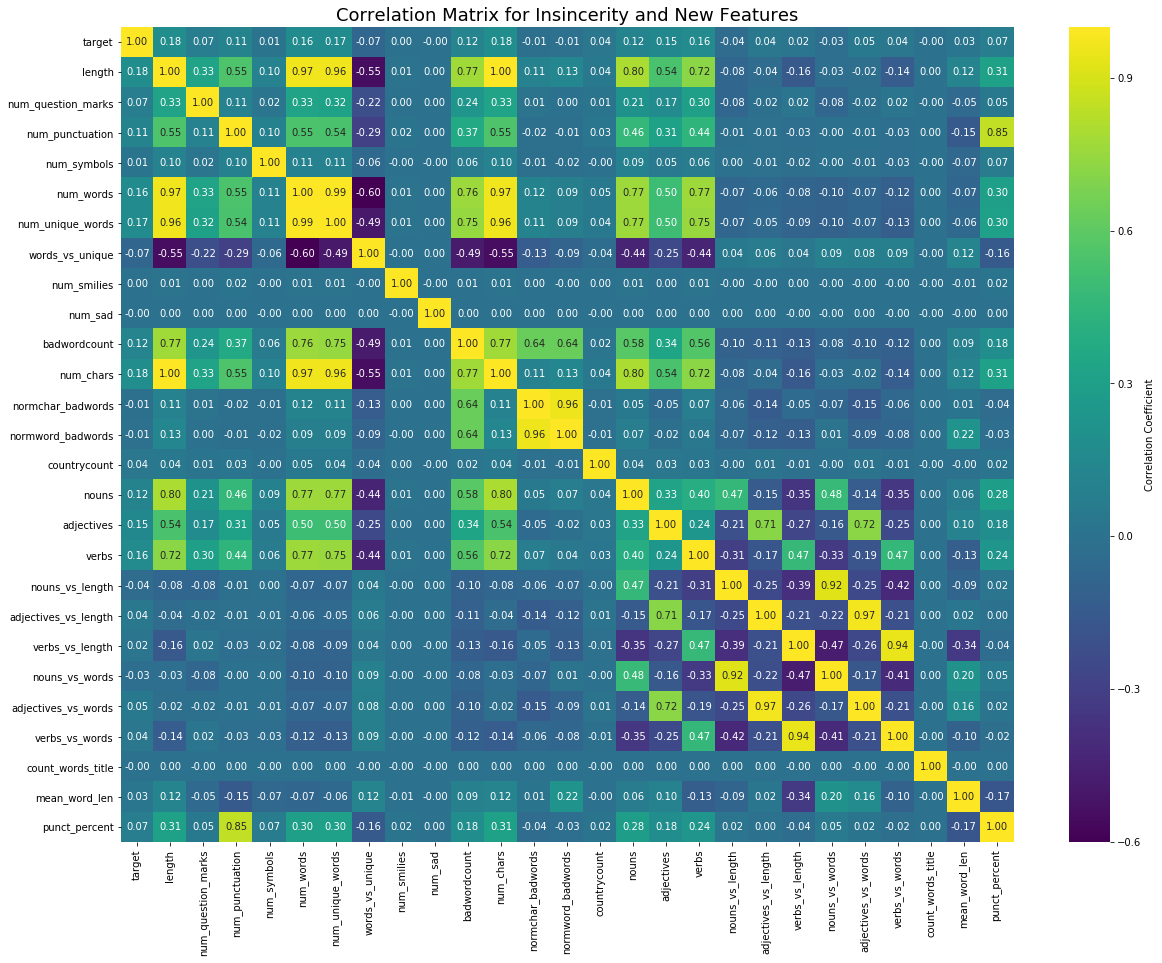

In [56]:
f, ax = plt.subplots(figsize= [20,15])
sns.heatmap(train.corr(), annot=True, fmt=".2f", ax=ax, 
            cbar_kws={'label': 'Correlation Coefficient'}, cmap='viridis')
ax.set_title("Correlation Matrix for Insincerity and New Features", fontsize=18)
plt.show()

In [57]:
import re
import nltk
from nltk.stem.porter import PorterStemmer
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
stop = set(stopwords.words('english')) #set of stopwords
a=set(["not","did","didn't","does","doesn't","don't"])
stop=stop.difference(a)

i=0
str1=' '
final_string=[]
s=''
for sent in train['treated_question'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(cleaned_words.lower())
                    filtered_sentence.append(s)
                else:
                    continue
            else:
                continue 
    str1 = ' '.join(filtered_sentence) #final string of cleaned words
    final_string.append(str1)
    i+=1

In [58]:
train['treated_question']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [59]:
def ngram_extractor(text, n_gram):
    token = [token for token in text.lower().split(" ") if token != "" if token not in stop]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

# Function to generate a dataframe with n_gram and top max_row frequencies
def generate_ngrams(df, col, n_gram, max_row):
    temp_dict = defaultdict(int)
    for question in df[col]:
        for word in ngram_extractor(question, n_gram):
            temp_dict[word] += 1
    temp_df = pd.DataFrame(sorted(temp_dict.items(), key=lambda x: x[1])[::-1]).head(max_row)
    temp_df.columns = ["word", "wordcount"]
    return temp_df

def comparison_plot(df_1,df_2,col_1,col_2, space):
    fig, ax = plt.subplots(1, 2, figsize=(20,10))
    
    sns.barplot(x=col_2, y=col_1, data=df_1, ax=ax[0], color="palegreen")
    sns.barplot(x=col_2, y=col_1, data=df_2, ax=ax[1], color="palegreen")

    ax[0].set_xlabel('Word count', size=14, color="green")
    ax[0].set_ylabel('Words', size=14, color="green")
    ax[0].set_title('Top words in sincere questions', size=18, color="green")

    ax[1].set_xlabel('Word count', size=14, color="green")
    ax[1].set_ylabel('Words', size=14, color="green")
    ax[1].set_title('Top words in insincere questions', size=18, color="green")

    fig.subplots_adjust(wspace=space)
    
    plt.show()

In [60]:
ngram_extractor(train['treated_question'].to_string(),1)

['0',
 'did',
 'quebec',
 'nationalists',
 'see',
 'province',
 'nation\n1',
 'adopted',
 'dog',
 'would',
 'encourage',
 'people',
 'adopt',
 'not',
 'shop\n2',
 'does',
 'velocity',
 'affect',
 'time',
 'does',
 'velocity',
 'affect...\n3',
 'did',
 'otto',
 'von',
 'guericke',
 'used',
 'magdeburg',
 'hemispheres\n4',
 'convert',
 'montra',
 'helicon',
 'mountain',
 'bike',
 'changing',
 '...\n5',
 'gaza',
 'slowly',
 'becoming',
 'auschwitz',
 'dachau',
 'treblink...\n6',
 'does',
 'quora',
 'automatically',
 'ban',
 'conservative',
 'opin...\n7',
 'crazy',
 'wash',
 'wipe',
 'groceries',
 'germs',
 'everywhere\n8',
 'thing',
 'dressing',
 'moderately',
 'different',
 'dressing',
 'm...\n9',
 'ever',
 'phase',
 'wherein',
 'became',
 'ignorant',
 'people',
 'love...\n10',
 'say',
 'feminism\n11',
 'calgary',
 'flames',
 'founded\n12',
 'dumbest',
 'yet',
 'possibly',
 'true',
 'explanation',
 'trump',
 'el...\n13',
 'use',
 'external',
 'hard',
 'disk',
 'well',
 'data',
 'storage'

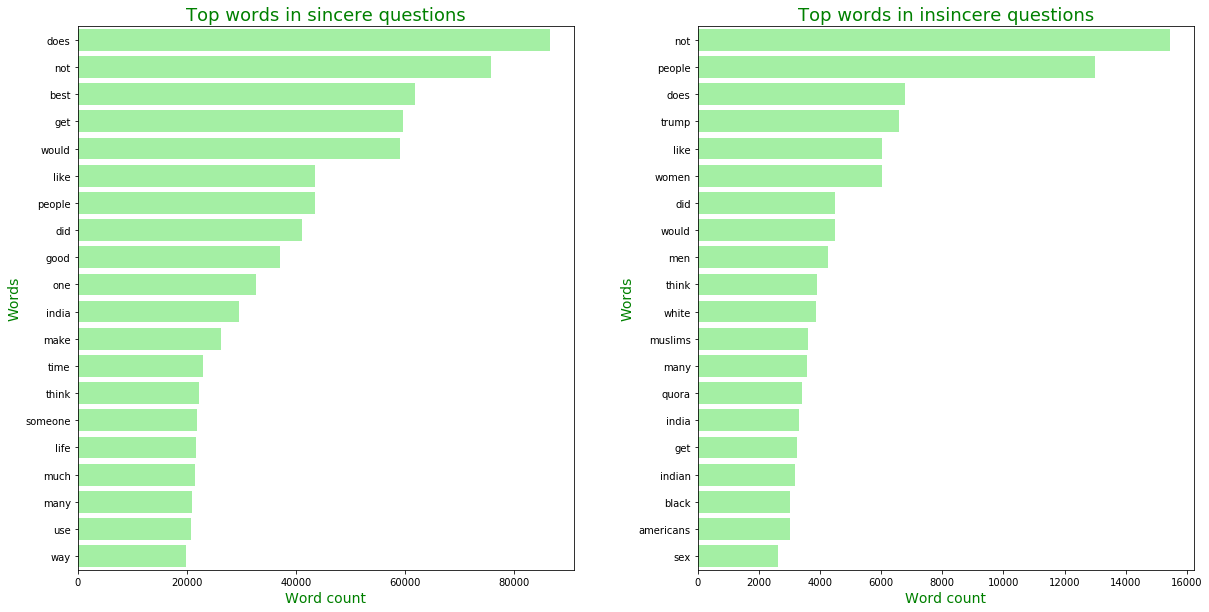

In [61]:
from collections import defaultdict
sincire=generate_ngrams(train[train["target"]==0],'treated_question',1,20)
insincire=generate_ngrams(train[train["target"]==1],'treated_question',1,20)
comparison_plot(sincire,insincire,'word','wordcount', 0.25)

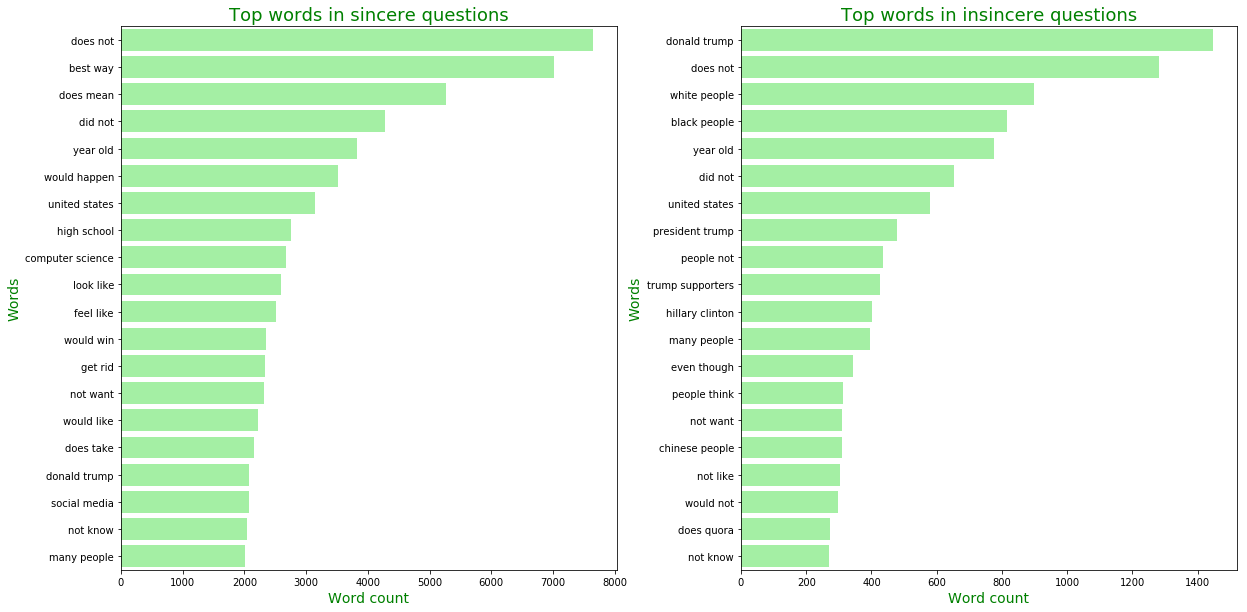

In [62]:
from collections import defaultdict
sincire=generate_ngrams(train[train["target"]==0],'treated_question',2,20)
insincire=generate_ngrams(train[train["target"]==1],'treated_question',2,20)
comparison_plot(sincire,insincire,'word','wordcount', 0.25)

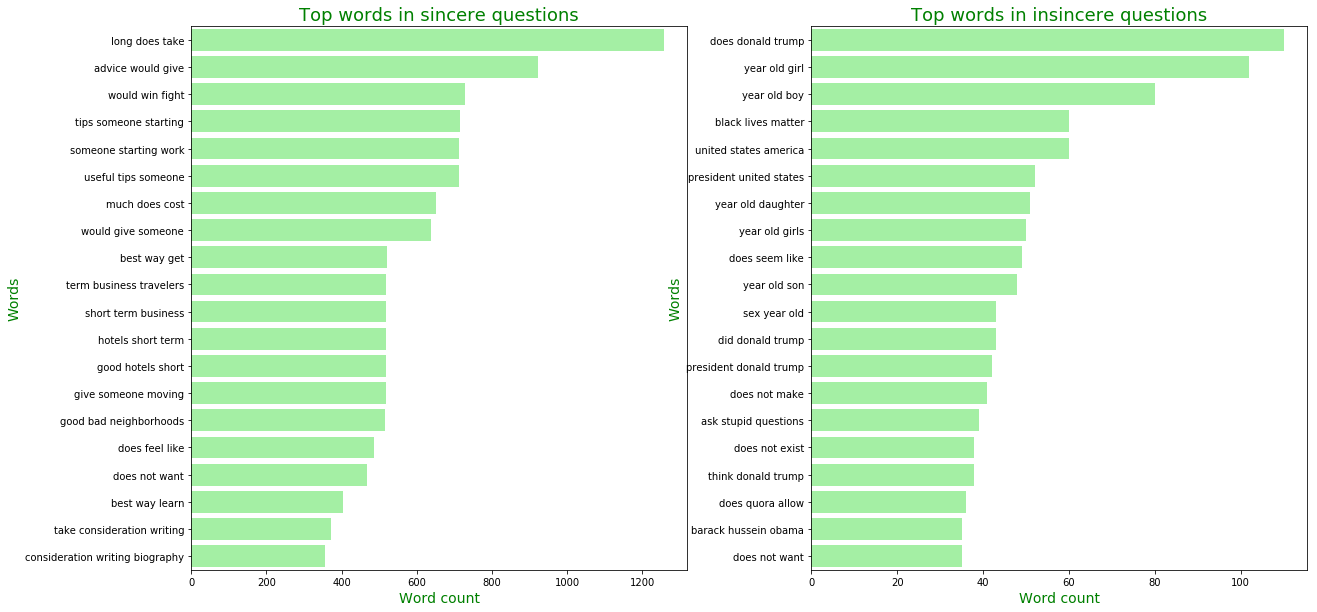

In [63]:
from collections import defaultdict
sincire=generate_ngrams(train[train["target"]==0],'treated_question',3,20)
insincire=generate_ngrams(train[train["target"]==1],'treated_question',3,20)
comparison_plot(sincire,insincire,'word','wordcount', 0.25)

In [1]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(train, test_size=0.2)

NameError: name 'train' is not defined

In [ ]:
#from sklearn.model_selection import train_test_split
#train, cv = train_test_split(train1, test_size=0.2)

In [ ]:
train.shape,test.shape

In [ ]:
y_train=train['target']

In [ ]:
x_train=train.drop(['target'],axis=1)

In [ ]:
#y_cv=cv['target']
#x_cv=cv.drop(['target'],axis=1)
y_test=test['target']

x_test=test.drop(['target'],axis=1)



In [ ]:
print

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer()
reviews_tfidf = tf_idf_vect.fit_transform(x_train['treated_question'].values)
#reviews_tfidf1 = tf_idf_vect.transform(x_cv['treated_question'].values)
reviews_tfidf2 = tf_idf_vect.transform(x_test['treated_question'].values)

In [71]:
reviews_tfidf.shape,reviews_tfidf2.shape

((1044897, 158899), (261225, 158899))

In [72]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB

nb = BernoulliNB()
param_grid = {'alpha':[1000,100,10,1,0.1,0.01,0.001]} #params we need to try on classifier
gsv = GridSearchCV(nb,param_grid,cv=2,verbose=1,n_jobs=-1,scoring='f1')
gsv.fit(reviews_tfidf,y_train)


Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    9.9s finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [1000, 100, 10, 1, 0.1, 0.01, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [73]:
print(gsv.best_estimator_)
print(gsv.score(reviews_tfidf2, y_test))

BernoulliNB(alpha=0.1, binarize=0.0, class_prior=None, fit_prior=True)
0.5424854020788409


In [74]:
nb = BernoulliNB(alpha=0.1)
nb.fit(reviews_tfidf,y_train)

BernoulliNB(alpha=0.1, binarize=0.0, class_prior=None, fit_prior=True)

Accuracy on test set: 92.771%
Precision on test set: 0.448
Recall on test set: 0.687
F1-Score on test set: 0.542
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



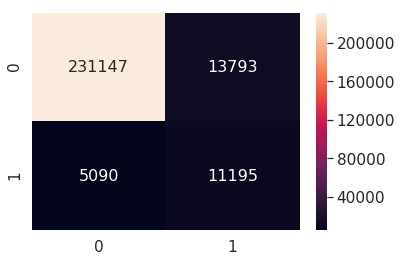

In [76]:
y_pred = nb.predict(reviews_tfidf2)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")


df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')